<a href="https://colab.research.google.com/github/SiracencoSerghei/DataScienceHW/blob/main/HW8/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](https://en.wikipedia.org/wiki/MNIST_database), або [тут](https://www.tensorflow.org/datasets/catalog/mnist), a [також тут](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)

In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [41]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [42]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [43]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)  # Сигмоїда для першого шару
    x = self.layer2(x, activation=0)  # Сигмоїда для другого шару
    x = self.output_layer(x, activation=1)  # Softmax для вихідного шару
    return x

In [44]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислюємо точність
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Виводимо результат
    print("Точність моделі:", accuracy.numpy())

    return accuracy

In [45]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [46]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss:.2f}, Accuracy: {acc:.2f}")


Точність моделі: 0.625
Step: 100, Loss: 350.67, Accuracy: 0.62
Точність моделі: 0.73046875
Step: 200, Loss: 239.17, Accuracy: 0.73
Точність моделі: 0.83203125
Step: 300, Loss: 188.63, Accuracy: 0.83
Точність моделі: 0.8203125
Step: 400, Loss: 151.29, Accuracy: 0.82
Точність моделі: 0.84765625
Step: 500, Loss: 138.92, Accuracy: 0.85
Точність моделі: 0.8359375
Step: 600, Loss: 140.13, Accuracy: 0.84
Точність моделі: 0.90234375
Step: 700, Loss: 87.67, Accuracy: 0.90
Точність моделі: 0.875
Step: 800, Loss: 119.48, Accuracy: 0.88
Точність моделі: 0.88671875
Step: 900, Loss: 100.16, Accuracy: 0.89
Точність моделі: 0.83984375
Step: 1000, Loss: 152.99, Accuracy: 0.84
Точність моделі: 0.890625
Step: 1100, Loss: 91.75, Accuracy: 0.89
Точність моделі: 0.87109375
Step: 1200, Loss: 95.88, Accuracy: 0.87
Точність моделі: 0.859375
Step: 1300, Loss: 95.65, Accuracy: 0.86
Точність моделі: 0.91796875
Step: 1400, Loss: 98.12, Accuracy: 0.92
Точність моделі: 0.90625
Step: 1500, Loss: 67.14, Accuracy: 0.91

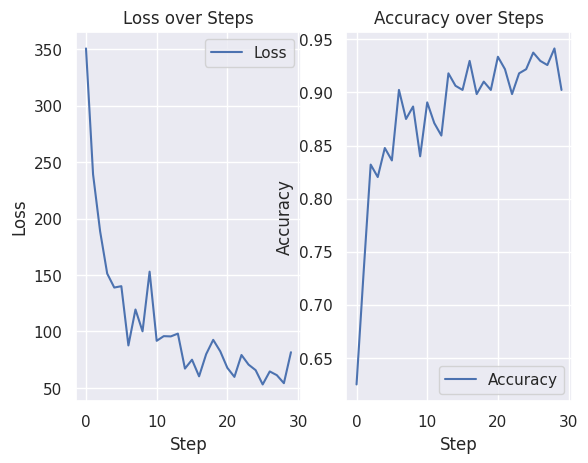

In [47]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.legend()
# Виведіть графік точності
# Місце для вашого коду
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy over Steps')
plt.legend()

plt.show()

In [48]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
test_pred = neural_net(x_test)

# Тестування моделі на тестових даних
# Місце для вашого коду
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")


Точність моделі: 0.9034
Test Accuracy: 0.9034000039100647


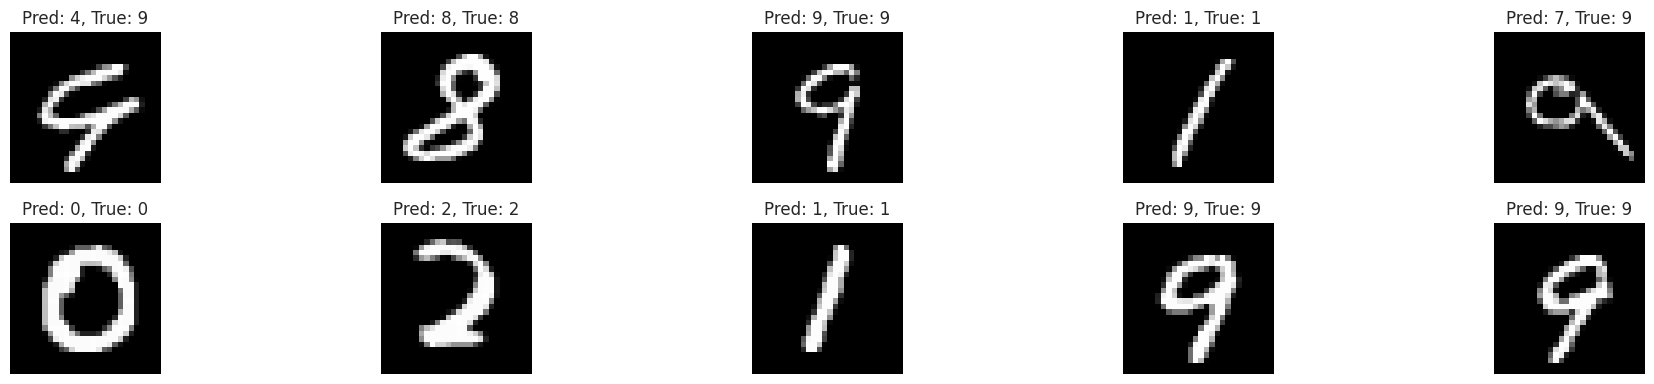

Кількість правильних передбачень: 8 з 10
Точність на цих 10 зображеннях: 80.00%


In [49]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
random_indices = random.sample(range(len(x_test)), 10)

# Створимо графік для відображення 10 зображень
plt.figure(figsize=(20, 4))

for i, idx in enumerate(random_indices):
    # Відобразимо зображення
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')

    # Отримаємо передбачення нейронної мережі
    pred_label = tf.argmax(neural_net(x_test[idx:idx+1]), 1).numpy()[0]
    true_label = y_test[idx]

    # Додамо заголовок з передбаченням та правильною міткою
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Зробимо висновок про помилки
correct_predictions = 0
for i, idx in enumerate(random_indices):
    pred_label = tf.argmax(neural_net(x_test[idx:idx+1]), 1).numpy()[0]
    true_label = y_test[idx]
    if pred_label == true_label:
        correct_predictions += 1

print(f"Кількість правильних передбачень: {correct_predictions} з 10")
print(f"Точність на цих 10 зображеннях: {(correct_predictions / 10) * 100:.2f}%")

---
# Висновки
---

У деяких випадках модель досягає точності 100%, а на інших — 90% чи 80%. Це досить високі показники, які підходять для багатьох реальних застосунків.

Однак, якщо задачі вимагають ще кращих результатів, можна підвищити точність, збільшивши обсяг навчальної вибірки або змінюючи архітектуру нейронної мережі.